MS Studio

When entering a new business, Microsoft has one tradition. Strive for excellence. Our goal with Microsoft Studio is to perpetuate this tradition. 

Every year, thousands of new movies are released. Some are acclaimed by the critics; others are box office success. Our goal is to release movies that are both, critic and box office success. 
First, less take a look on this 2x2 matrice of all the movies that were released during the last 10 years.

In [40]:
#Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
!pip install mysql-connector-python

In [41]:
#Connecting SQL

import mysql.connector
con = mysql.connector.connect(user = 'hbs-student', password = 'super-secure-password?', host = 'hbs-ds-060120.c1doesqrid0e.us-east-1.rds.amazonaws.com', database = 'movies')
cur = con.cursor()

In [4]:
#Creating df_all from IMDB ratings

cur.execute("""SELECT *
                FROM movies.imdb_title_ratings
                JOIN movies.imdb_title_basics USING(tconst)
                WHERE imdb_title_basics.start_year >= 2010
                AND imdb_title_ratings.numvotes > 50;""")



df_all = pd.DataFrame(cur.fetchall())
df_all.columns = [x[0] for x in cur.description]

# Remove special characters
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df_all['primary_title'] = df_all['primary_title'].str.replace(char, ' ')
    
#put Title in low caps
df_all['primary_title'] =  df_all['primary_title'].map(lambda x: x.lower())

df_all.head(2)

,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,7.00,77,sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0069049,6.90,4517,the other side of the wind,The Other Side of the Wind,2018,122.0,Drama


In [5]:
#Creating df_roi from tn_movie_budgets

df_roi = pd.read_sql_query('select * from tn_movie_budgets', con)
df_roi ["release_date"] = pd.to_datetime(df_roi ["release_date"]) 
df_roi.head()

#Cleaning those 3 columns
df_roi ["production_budget"] = df_roi ["production_budget"].map(lambda x: x.lstrip('$')).str.replace(',','')
df_roi ["domestic_gross"] = df_roi ["domestic_gross"].map(lambda x: x.strip('$,')).str.replace(',','')
df_roi ["worldwide_gross"] = df_roi ["worldwide_gross"].map(lambda x: x.strip('$,')).str.replace(',','')
df_roi = df_roi.astype({"production_budget":'int64', "domestic_gross":'int64',"worldwide_gross":'int64'}) 

#New column roi metrics that show you 
df_roi ["roi"] = (df_roi ["worldwide_gross"])/df_roi ["production_budget"]
df_roi = df_roi.sort_values("roi",ascending = 0)

# Selecting movies after 2000
df_roi['year'] = df_roi['release_date'].apply(lambda x: x.year)
df_roi = df_roi.loc [df_roi['year'] > 2010]

#Rename column
df_roi = df_roi.rename(columns={'movie': 'primary_title'})

# Remove special characters
spec_chars = ["!",'"',"#","%","&","'","(",")",
              "*","+",",","-",".","/",":",";","<",
              "=",">","?","@","[","\\","]","^","_",
              "`","{","|","}","~","–"]
for char in spec_chars:
    df_roi['primary_title'] = df_roi['primary_title'].str.replace(char, ' ')
    
#put Title in low caps
df_roi['primary_title'] =  df_roi['primary_title'].map(lambda x: x.lower())

#Rename column
df_roi = df_roi.rename(columns={'movie': 'primary_title'})

df_roi.head()

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,roi,year
5679,80,2015-07-10,the gallows,100000,22764410,41656474,416.564740,2015
5211,12,2012-01-06,the devil inside,1000000,53262945,101759490,101.759490,2012
5062,63,2011-04-01,insidious,1500000,54009150,99870886,66.580591,2011
5213,14,2015-04-17,unfriended,1000000,32789645,64364198,64.364198,2015
4249,50,2017-01-20,split,5000000,138141585,278964806,55.792961,2017


In [6]:
#Left merge between df_roi and df_all
left_join_df = df_roi.merge(df_all, on='primary_title', how='left' )

#Drop if ROI or Rating is NA
left_join_df = left_join_df.dropna(subset = ["averagerating", "roi"])

Text(0, 0.5, 'Rating')

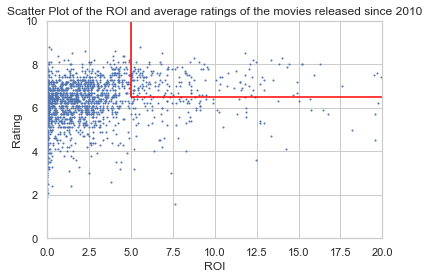

In [7]:
plt.scatter(left_join_df['roi'] , left_join_df['averagerating'], marker="o", s=1)
plt.xlim(0, 20)
plt.ylim(0, 10)

plt.hlines(y=6.5, xmin=5, xmax=20, color='red')
plt.vlines(x=5, ymin=6.5, ymax=10, color='red')


plt.title("Scatter Plot of the ROI and average ratings of the movies released since 2010")
plt.xlabel('ROI')
plt.ylabel('Rating') 

We are using 2 metrics to evaluate the movies:
- the average rating on IMDB, only for movies with more than 50 ratings
- the Return on Investment (ROI), which is the wordlwide revenue generated by a movie divided by the movie's budget

We will focus our presentation on movies that have a ROI over 5 and an average rating > 6.5

The first thing we would like to know is what is the best month to release a "succesful" movie

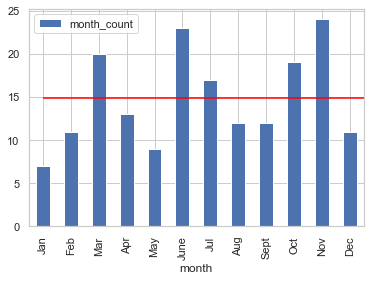

In [33]:
# What's the best month to release a movie?
df_join = left_join_df.loc [left_join_df['averagerating'] > 6.5]
df_join = df_join.loc [df_join ['roi'] > 5]

df_join['month'] = df_join['release_date'].apply(lambda x: x.month)

graph_month = df_join.groupby('month').count().sort_values(by = 'month', ascending = True)
graph_month = graph_month.tconst.reset_index()
graph_month = graph_month.rename(columns={"tconst": "month_count"})
graph_month

#Put month in text instead of number
dic_month = {1 : "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "June", 7:"Jul", 8:"Aug", 9:"Sept", 10:"Oct", 11:"Nov", 12:"Dec"}
graph_month["month"] =graph_month.month.map(dic_month)

# Plot the bar char for graph_month
ax = graph_month.plot( x='month', y='month_count', kind='bar')
plt.hlines(y= graph_month["month_count"].mean(), xmin=0, xmax=20, color='red')

In [10]:
#Let's now take a look at the most succesfull genre

In [11]:
#Spliting genres into columns

df_join[['Genres_1', 'Genres_2', 'Genres_3']] = df_join.genres.str.split(",", expand=True)
df_join.head(5)


,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,roi,year,tconst,averagerating,numvotes,original_title,start_year,runtime_minutes,genres,month,Genres_1,Genres_2,Genres_3
2,63,2011-04-01,insidious,1500000,54009150,99870886,66.580591,2011,tt1591095,6.90,254197.0,Insidious,2010.0,103.0,"Horror,Mystery,Thriller",4,Horror,Mystery,Thriller
6,50,2017-01-20,split,5000000,138141585,278964806,55.792961,2017,tt4972582,7.30,358543.0,Split,2016.0,117.0,"Horror,Thriller",1,Horror,Thriller,None
9,49,2017-02-24,get out,5000000,176040665,255367951,51.073590,2017,tt5052448,7.70,400474.0,Get Out,2017.0,104.0,"Horror,Mystery,Thriller",2,Horror,Mystery,Thriller
11,64,2016-10-21,moonlight,1500000,27854931,65245512,43.497008,2016,tt4975722,7.40,227964.0,Moonlight,2016.0,111.0,Drama,10,Drama,None,None
16,56,2016-12-21,dangal,9500000,12391761,294654618,31.016276,2016,tt5074352,8.50,123638.0,Dangal,2016.0,161.0,"Action,Biography,Drama",12,Action,Biography,Drama


In [12]:
arr_genres = df_join.Genres_1.unique()
arr_genres

list_genres = arr_genres.tolist()
###list_genres.remove('')

genres_count = []
for genre in list_genres:
    genres_count.append(df_join['genres'].apply(lambda x: genre in x).astype(np.uint8).sum())
genres_count 

#df['isAdventure'] = df['genres'].apply(lambda x: 'Adventure' in x).astype(np.uint8)
#total_adventure = df['isAdventure'].sum()

[15, 107, 40, 60, 24, 15, 37, 4, 15, 9, 16]

In [13]:
#Connecting two lists to dictionary and transforming to DataFrame
#Sorting values by count (sum of all three genre types)

genres_cumulative = {'genres': list_genres, 'genres_count': genres_count}
genres_total = pd.DataFrame.from_dict(genres_cumulative)
genres_total.sort_values(by = 'genres_count', ascending = False)

,genres,genres_count
1,Drama,107
3,Comedy,60
2,Action,40
6,Adventure,37
4,Biography,24
10,Mystery,16
0,Horror,15
5,Crime,15
8,Animation,15
9,Family,9


In [17]:
genres_total["genres_count"].mean()

31.09090909090909

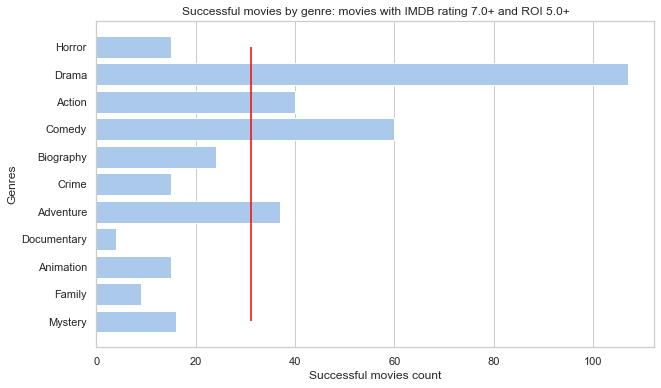

In [38]:
#OPTION 1

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

sns.set_color_codes("pastel")
sns.barplot(x="genres_count", y="genres", data= genres_total,
            label="Successful movies by genres", color="b")
ax.set_xlabel('Successful movies count')
ax.set_ylabel('Genres')
ax.set_title('Successful movies by genre: movies with IMDB rating 7.0+ and ROI 5.0+')

plt.vlines(x= genres_total["genres_count"].mean(), ymin=0, ymax=10, color='red')

In [42]:
#Importing SQL data (IMDB Ratings)

cur.execute("""SELECT *
                FROM movies.imdb_title_ratings
                JOIN movies.imdb_title_basics USING (tconst)
                JOIN movies.imdb_title_crew USING (tconst)
                LEFT JOIN movies.imdb_name_basics ON movies.imdb_name_basics.nconst = movies.imdb_title_crew.directors
                WHERE imdb_title_basics.start_year >= 2010
                AND imdb_title_ratings.averagerating >6.5
                AND imdb_title_ratings.numvotes > 50;""")

df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()


,tconst,averagerating,numvotes,primary_title,original_title,start_year,runtime_minutes,genres,directors,writers,nconst,primary_name,birth_year,death_year,primary_profession,known_for_titles
0,tt0063540,7.00,77,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",nm0712540,"nm0023551,nm1194313,nm0347899,nm1391276",nm0712540,Harnam Singh Rawail,1921.0,2004.0,"director,writer,producer","tt0266757,tt0266712,tt0134996,tt0266765"
1,tt0069049,6.90,4517,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,nm0000080,"nm0000080,nm0462648",nm0000080,Orson Welles,1915.0,1985.0,"actor,director,writer","tt0048393,tt0052311,tt0057427,tt0033467"
2,tt0137204,8.10,263,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",nm0365480,nm0365480,nm0365480,Anthony Harrison,1961.0,NaN,"actor,writer,producer","tt5615700,tt0298814,tt0137204,tt6461824"
3,tt0146592,6.80,451,Pál Adrienn,Pál Adrienn,2010,136.0,Drama,nm1030585,"nm1030585,nm1921430",nm1030585,Ágnes Kocsis,1971.0,NaN,"director,writer,producer","tt0146592,tt0291503,tt0461424,tt0484487"
4,tt0159369,7.60,53,Cooper and Hemingway: The True Gen,Cooper and Hemingway: The True Gen,2013,180.0,Documentary,nm0611850,nm0611850,nm0611850,John Mulholland,NaN,NaN,"director,writer,producer","tt6609564,tt0359475,tt0159369,tt4332600"


In [26]:
#Renaming director column
df_join = df_join.rename(columns={"primary_name": "director_name"})
df_join.head(5)

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross,roi,year,tconst,averagerating,numvotes,original_title,start_year,runtime_minutes,genres,month,Genres_1,Genres_2,Genres_3
2,63,2011-04-01,insidious,1500000,54009150,99870886,66.580591,2011,tt1591095,6.90,254197.0,Insidious,2010.0,103.0,"Horror,Mystery,Thriller",4,Horror,Mystery,Thriller
6,50,2017-01-20,split,5000000,138141585,278964806,55.792961,2017,tt4972582,7.30,358543.0,Split,2016.0,117.0,"Horror,Thriller",1,Horror,Thriller,None
9,49,2017-02-24,get out,5000000,176040665,255367951,51.073590,2017,tt5052448,7.70,400474.0,Get Out,2017.0,104.0,"Horror,Mystery,Thriller",2,Horror,Mystery,Thriller
11,64,2016-10-21,moonlight,1500000,27854931,65245512,43.497008,2016,tt4975722,7.40,227964.0,Moonlight,2016.0,111.0,Drama,10,Drama,None,None
16,56,2016-12-21,dangal,9500000,12391761,294654618,31.016276,2016,tt5074352,8.50,123638.0,Dangal,2016.0,161.0,"Action,Biography,Drama",12,Action,Biography,Drama


In [ ]:
df_new_join = df_join(df,on)
left_join_df = df_roi.merge(df_all, on='primary_title', how='left' )

In [27]:
directors_roi = round(df_join[['director_name', 'roi']].groupby('director_name').mean(),2)
top_directors_roi = top_directors.join(directors_roi,on = 'director_name',lsuffix= "A", rsuffix= "B").sort_values("roi", ascending=False) 
top_directors_roi

KeyError: "['director_name'] not in index"

In [28]:
#Left join between df_roi et df
left_join_df_roi = df_roi.merge(df, on='primary_title', how='left' )
df_join = left_join_df_roi.dropna(subset = ["averagerating", "roi"])


NameError: name 'df' is not defined